## THE QUESTION: 
## What Vancouver Neighbourhood Appears the 'Greenest'?

My question is whether I could quantify how *green* a neighbourhood feels. In other words, how densely vegetated are the various neighbourhoods in Vancouver?

Given the broad nature of this question, I explored several approaches. Ultimately, I found that ranking neighborhood greenness by the average distance between street trees yielded results that conformed to common sense and randomly picked street views. This method leverages quantifiable data on both the number of trees and the length of public streets, which are key components in defining the green character of an area.

---

Importing in all the libraries required.

In [90]:
import geopandas as gpd
from shapely import Polygon, Point
import matplotlib.pyplot as plt

## THE DATASETS

I ended up using 4 different datasets.

* [Local Area Boundaries](https://opendata.vancouver.ca/explore/dataset/local-area-boundary/information/?disjunctive.name)
    * This dataset represents the official boundaries of the various neighbourhoods in Vancouver.
    * I have assigned this data to the variable `nbrhoods`.
* [Shoreline](https://opendata.vancouver.ca/explore/dataset/shoreline-2002/information/)
    * This dataset represents the shoreline of Vancouver.
    * When booleaned with the *Local Area Boundaries* above, I am able to get an accurate area for each neighbourhood.
    * I have assigned this data to the variable `shore_line`.
* [Street Trees](https://opendata.vancouver.ca/explore/dataset/street-trees/information/?disjunctive.species_name&disjunctive.common_name&disjunctive.on_street&disjunctive.neighbourhood_name)
    * This dataset marks all city maintained, public street adjacent trees.
    * I have assigned this data to the variable `street_trees`.
* [public streets dataset](https://opendata.vancouver.ca/explore/dataset/public-streets/information/?location=12,49.23899,-123.13264)
    * This dataset represents all public streets within the city.
    * I have assigned this data to the variable `streets`.

All except for `streets` were downloaded as `.geojson` files. `streets` was downloaded as a `.parquet` file. All were downloaded in the CRS, EPSG:26910.

### Neighbourhoods - Pt 1 - Import

In [91]:
# import the neighbourhoods dataset
nbrhoods = gpd.read_file("data/neighbourhoods.geojson")

# copy the desired columns into a new geodataframe in the proper order
nbrhoods = nbrhoods[["name", "geometry"]]

# reproject the data to epsg 26910
nbrhoods = nbrhoods.set_crs(epsg=26910, allow_override=True)

# previewing the geodataframe to make sure our data is correct / in the proper order
nbrhoods.head(5)

name                                           geometry
0          Downtown  POLYGON ((491836.349 5459718.919, 492419.675 5...
1  Hastings-Sunrise  POLYGON ((495892.653 5460083.767, 496226.106 5...
2        Kerrisdale  POLYGON ((486957.91 5451434.123, 487209.002 54...
3           Marpole  POLYGON ((492208.402 5450157.053, 491875.556 5...
4          Oakridge  POLYGON ((492310.707 5453376.091, 492269.051 5...

<Axes: >

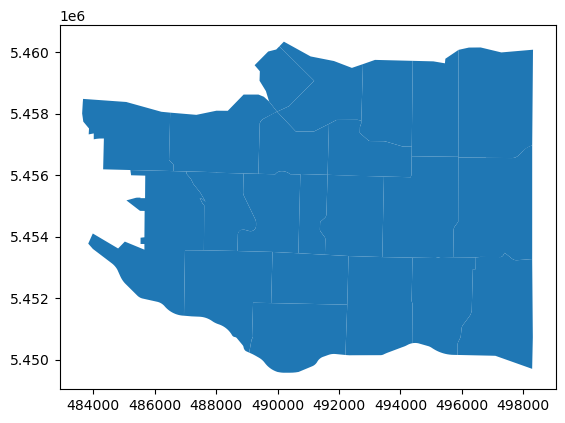

In [92]:
# previewing the plot to check projection
nbrhoods.plot()

### Neighbourhoods - Pt2 - Intersection with Shorelines

You'll notice that the local area boundaries extend beyond the shoreline. If we were to run a calculation based on these areas, we would end up with incorrect results. As such, we should intersect this data with the *shoreline* dataset to get the proper areas.

<img src="img\local_area.png" width="800"> 

In [93]:
# create the shorline polygon from scratch
shore_line = gpd.read_file("data/shoreline.geojson")

# grab only the geometry column - checked that it was active
shore_line = shore_line[["geometry"]]

# set CRS to epsg:26910
shore_line.set_crs(epsg=26910, allow_override=True)

# preview data
shore_line.head(4)

geometry
0  LINESTRING (496830.267 5450260.3259, 496835.56...
1  LINESTRING (498336.793 5460078.3979, 498328.63...

Since our neighbourhood blocks are `polygon` objects, we need to convert our `linestring` shoreline objects to a single polygon that we can then intersect with our neighbourhoods' geometry.

In [94]:
# return the coordinates of the shoreline as 2 columns
shore_coords = shore_line.get_coordinates()

shore_coords

x             y
0   496830.267  5.450260e+06
0   496835.561  5.450259e+06
0   496839.362  5.450257e+06
0   496843.077  5.450256e+06
0   496845.866  5.450255e+06
..         ...           ...
1   496824.878  5.450262e+06
1   496826.563  5.450261e+06
1   496828.226  5.450261e+06
1   496829.279  5.450261e+06
1   496830.267  5.450260e+06

[29454 rows x 2 columns]

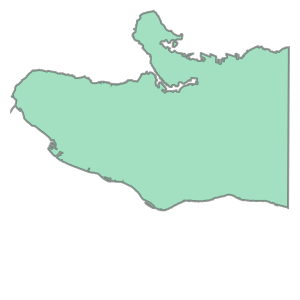

In [95]:
# we will reset the index so that it's just number from 0 to 29453 - note above, it's just 1 and 2
shore_coords = shore_coords.reset_index()

# Create new Shapely polygon object from shore_coords
shore_poly = Polygon(zip(shore_coords["x"], shore_coords["y"]))

# looks good!
shore_poly

We can now intersect our shoreline with our neighbourhoods geodataframe.

In [96]:
# geometric intersection
nbrhoods["geometry"] = nbrhoods["geometry"].intersection(shore_poly)

# double check
nbrhoods.head(3)

name                                           geometry
0          Downtown  MULTIPOLYGON (((492122.3 5459609.575, 492114.0...
1  Hastings-Sunrise  POLYGON ((498310.78 5460031.602, 498285.417 54...
2        Kerrisdale  MULTIPOLYGON (((486990.723 5453564.626, 487606...

<Axes: >

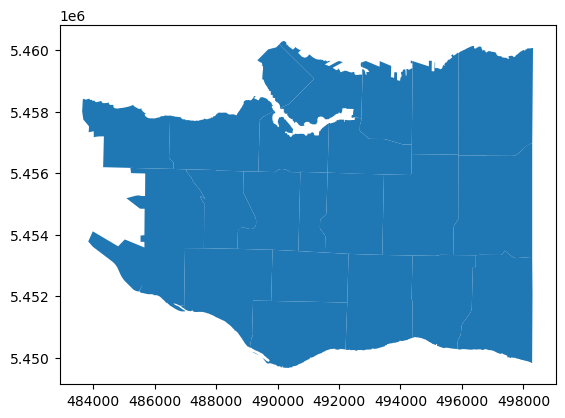

In [97]:
nbrhoods.plot()

We can finally add an area column now that we have the real shapes of the neighbourhoods.

In [98]:
nbrhoods["Area (m)"] = nbrhoods["geometry"].area

nbrhoods.head(4)

name                                           geometry  \
0          Downtown  MULTIPOLYGON (((492122.3 5459609.575, 492114.0...   
1  Hastings-Sunrise  POLYGON ((498310.78 5460031.602, 498285.417 54...   
2        Kerrisdale  MULTIPOLYGON (((486990.723 5453564.626, 487606...   
3           Marpole  MULTIPOLYGON (((489640.785 5449834.316, 489611...   

       Area (m)  
0  3.752654e+06  
1  8.021899e+06  
2  6.354107e+06  
3  5.607073e+06

### Street Trees
We will now import the [street trees dataset](https://opendata.vancouver.ca/explore/dataset/street-trees/information/?disjunctive.species_name&disjunctive.common_name&disjunctive.on_street&disjunctive.neighbourhood_name). This dataset is quite large when we consider the entire city and as such, we will download it as a `.parquet` file.

In [99]:
trees = gpd.read_parquet("data/cov_trees.parquet")

# since we know the active geometry, let's just use that column
trees = trees[["geo_point_2d"]]

# that name is a bit awkward so let's rename it
trees = trees.rename_geometry("tree_pts")

# apply epsg:26910
trees = trees.set_crs(epsg=26910, allow_override=True)

#dropping NA rows if needed
trees = trees.dropna()

trees.head(3)

tree_pts
0  POINT (486558.311 5457642.058)
1  POINT (491295.534 5452229.534)
2  POINT (486529.902 5457626.563)

<Axes: >

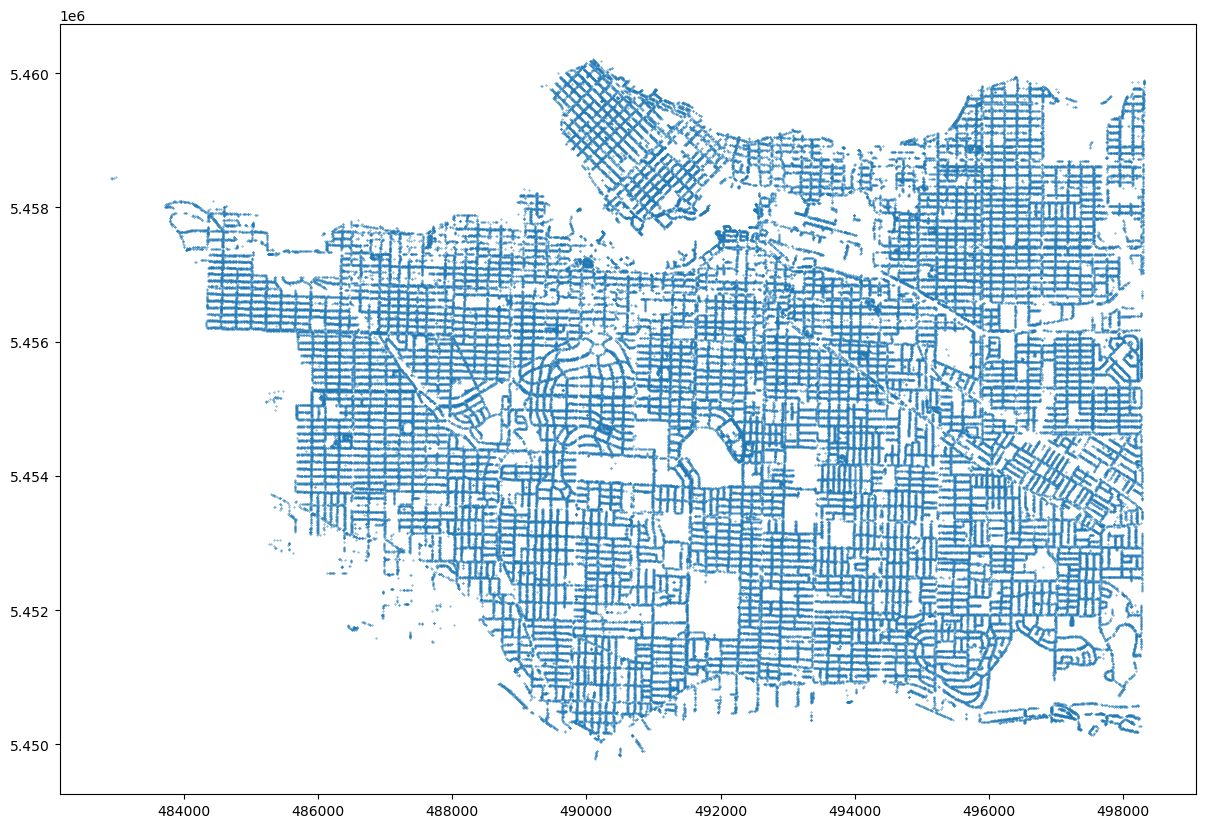

In [100]:
trees.plot(markersize = 0.1, figsize=(20, 10))

### Public Streets

In [101]:
# reading the public streets dataset in as a geodataframe
streets = gpd.read_file("data/streets.geojson")

# setting crs to epsg26910
streets = streets.set_crs(epsg=26910, allow_override=True)

# dropping null values
streets = streets.dropna()

# grabbing only the needed geometry column
streets = streets[["geometry"]]

# previewing data
streets.head(4)

geometry
0  LINESTRING (495215.264 5457324.704, 495258.451...
1  LINESTRING (495501.805 5457703.828, 495501.018...
2  LINESTRING (496573.922 5455017.703, 496573.905...
3  LINESTRING (496783.556 5455318.016, 496784.758...

<Axes: >

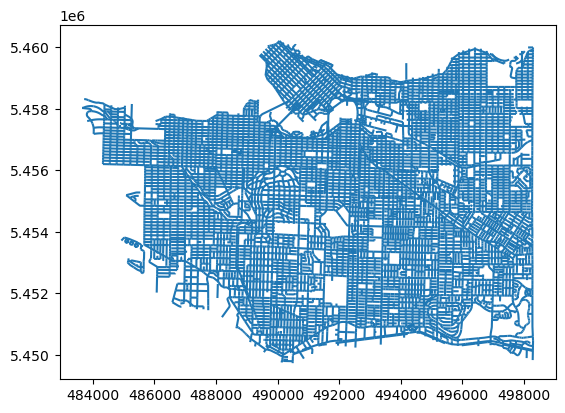

In [102]:
streets.plot()

---

## ANALYSIS 01 - Trees Per Neighbourhood
My first attempt to quantify the *greenness* of each neighbourhood simply counted how many trees there were per neighbourhood in Vancouver. I however, realized this wasn't a good rubric as areas might vary from neighbourhood to neghbourhood.

In [103]:
# perform a spatial join to group trees by neighbourhood
trees_in_nbrhds = gpd.sjoin(
    trees, 
    nbrhoods, 
    how='left',
    predicate="within",
)

# previewing the dataframe
trees_in_nbrhds.head(6)

tree_pts  index_right       name      Area (m)
0  POINT (486558.311 5457642.058)         18.0  Kitsilano  5.577874e+06
1  POINT (491295.534 5452229.534)          4.0   Oakridge  4.023603e+06
2  POINT (486529.902 5457626.563)         18.0  Kitsilano  5.577874e+06
3  POINT (490250.431 5452983.348)          4.0   Oakridge  4.023603e+06
4   POINT (490261.06 5452982.774)          4.0   Oakridge  4.023603e+06
5  POINT (490272.125 5452982.087)          4.0   Oakridge  4.023603e+06

<Axes: >

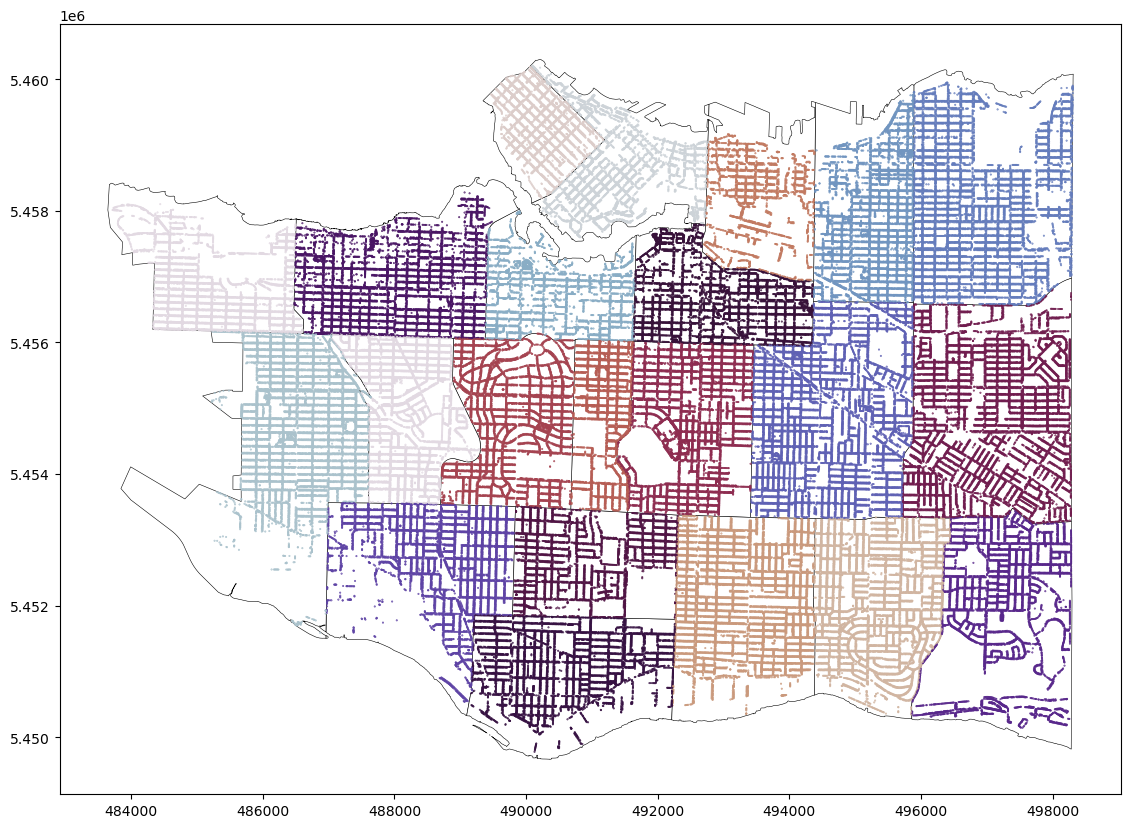

In [104]:
# plotting the trees per neighbourhood over the neighbourhoods dataframe

base = nbrhoods.plot(color='white', 
                     edgecolor='black', 
                     figsize=(20, 10), 
                     linewidth = 0.4)

trees_in_nbrhds.plot("name", ax=base, 
                     markersize = 0.2, 
                     cmap="twilight")

We can calculate the amount of trees per neighbourhood by counting the number of occurances of each neighbourhood name within the column `name` in our joined dataframe. To do so, we use the method `.value_counts()`.

In [105]:
# Calculating the street trees per neighbourhood
trees_num_nbrhd = trees_in_nbrhds["name"].value_counts()

# and sort by ascending
trees_num_nbrhd = trees_num_nbrhd.sort_values(ascending=True)

trees_num_nbrhd.head(6)

name
Strathcona      2837
West End        3338
South Cambie    3404
Fairview        4141
Oakridge        4797
Downtown        4809
Name: count, dtype: int64

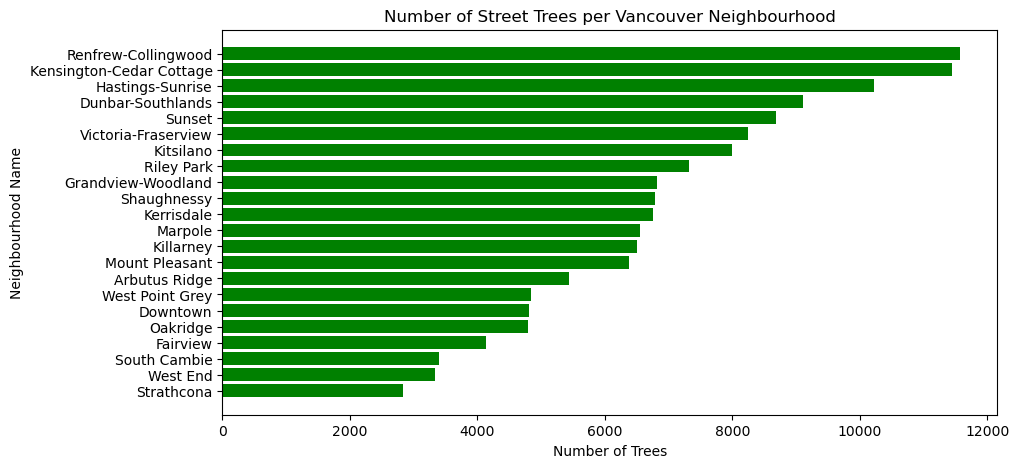

In [106]:
# PLOTTING

plot_names = list(trees_num_nbrhd.index)
plot_values = list(trees_num_nbrhd.values)

# set up the plot size and assign to a variable
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.barh(plot_names, plot_values, color="green")

# adjust the axes labels and title
plt.xlabel("Number of Trees")
plt.ylabel("Neighbourhood Name")
plt.title("Number of Street Trees per Vancouver Neighbourhood")

# show the plot
plt.show()

---

## ANALYSIS 02 - Trees per sq.M per Neighbourhood

My second analysis focused on trees per sq.M. This rubric logically was more correct than the first approach in that it accounted for variations in neighbourhood size. However, a few questions could poke holes in this analysis. For instance:
* How can we distiguish areas of private and public property within neighbourhoods?
* How can we distiguish between interior and exterior areas?

If I were to improve this approach, I could possibly import building footprints to subtract interior space. The first question led me to my third approach detailed in the next section.

Regardless, I started by combining the previous analysis back into the main `nbrhoods` dataframe in order to calculate the trees per sq. m.

In [107]:
# we can assign a new column to the nbrhoods dataframe using the name in the names column to grab the value by index
nbrhoods["tree count"] = [trees_num_nbrhd[nbr_name] for nbr_name in nbrhoods["name"]]

nbrhoods.head(4)

name                                           geometry  \
0          Downtown  MULTIPOLYGON (((492122.3 5459609.575, 492114.0...   
1  Hastings-Sunrise  POLYGON ((498310.78 5460031.602, 498285.417 54...   
2        Kerrisdale  MULTIPOLYGON (((486990.723 5453564.626, 487606...   
3           Marpole  MULTIPOLYGON (((489640.785 5449834.316, 489611...   

       Area (m)  tree count  
0  3.752654e+06        4809  
1  8.021899e+06       10219  
2  6.354107e+06        6748  
3  5.607073e+06        6559

In [108]:
# and now we can calculate the trees per square meter
nbrhoods["tree per sq. M"] = nbrhoods["tree count"] / nbrhoods["Area (m)"]

# and sort the rows by the new column
nbrhoods = nbrhoods.sort_values(by="tree per sq. M", ascending=True)

nbrhoods.head(4)

name                                           geometry  \
19         Strathcona  POLYGON ((492873.076 5459651.115, 492874.972 5...   
17          Killarney  POLYGON ((495859.368 5450489.396, 495859.933 5...   
9   Dunbar-Southlands  POLYGON ((487606.108 5453561.086, 486990.723 5...   
21    West Point Grey  POLYGON ((486506.363 5457849.452, 486470.863 5...   

        Area (m)  tree count  tree per sq. M  
19  3.875907e+06        2837        0.000732  
17  6.669148e+06        6500        0.000975  
9   8.895118e+06        9112        0.001024  
21  4.719099e+06        4841        0.001026

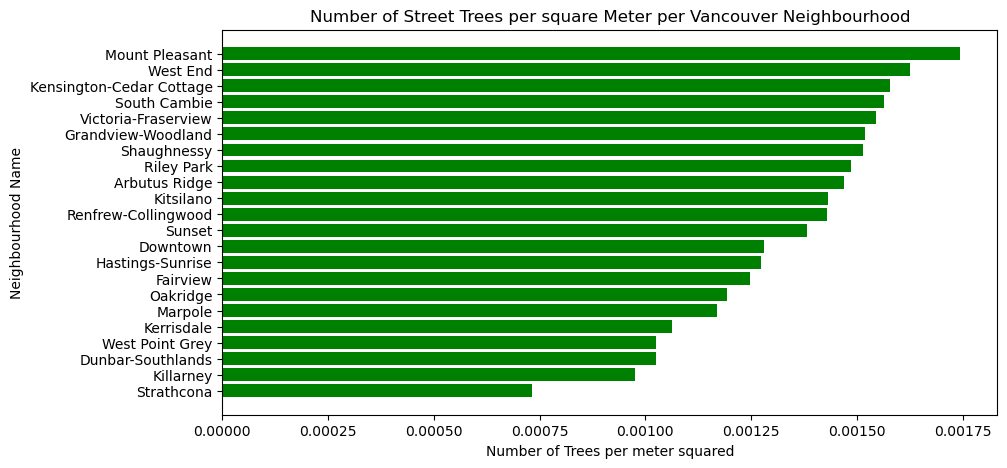

In [109]:
plot_names = list(nbrhoods["name"])
plot_values = list(nbrhoods["tree per sq. M"])


fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.barh(plot_names, plot_values, color ='green')

plt.xlabel("Number of Trees per meter squared")
plt.ylabel("Neighbourhood Name")
plt.title("Number of Street Trees per square Meter per Vancouver Neighbourhood")
plt.show()

## ANALYSIS 03 - Street Tree Spacing Along City Streets
Since our data set concerns trees lining streets in particular, it makes sense to calculate the average spacing per street trees along streets. This calculation will give us a meaningful indication of what parts of the city feel the most green as you walk through them.

<Axes: >

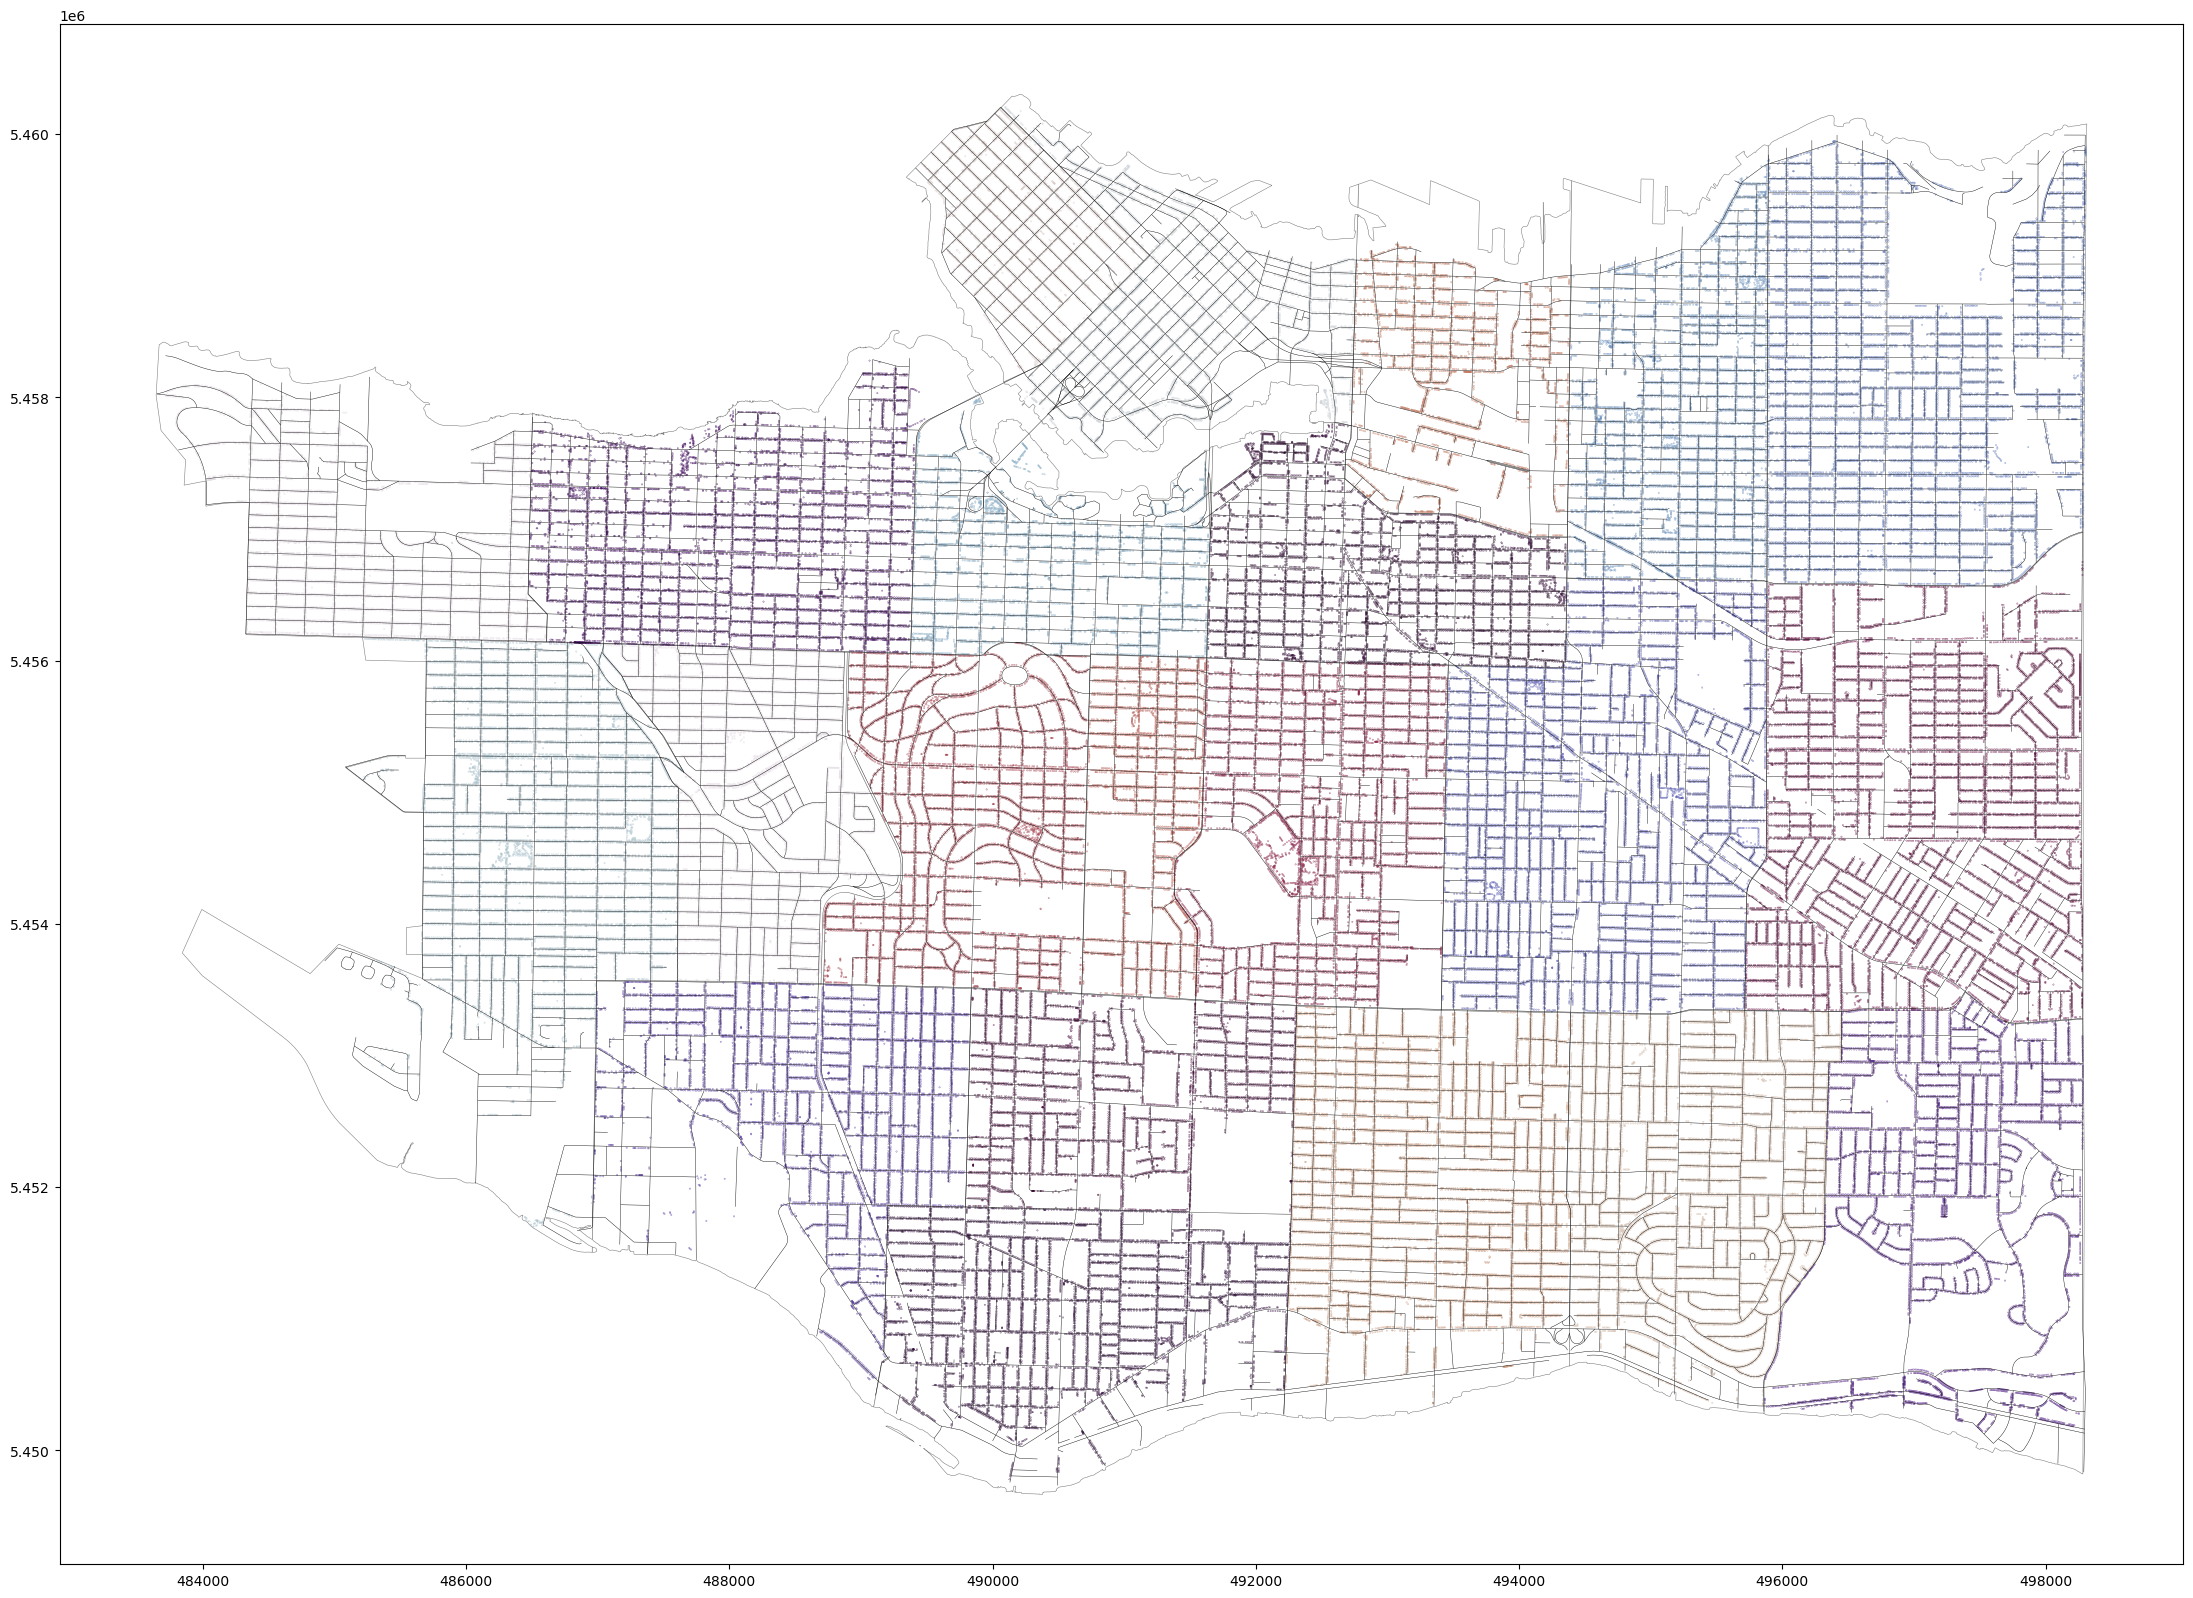

In [110]:
#visualizing our datasets
base = nbrhoods.plot(color='white', edgecolor='gray', figsize=(40, 20), linewidth = 0.4)

base_2 = trees_in_nbrhds.plot("name", ax=base, markersize = 0.05, cmap="twilight")

streets.plot(ax=base_2, aspect=1, linewidth = 0.3, color = 'black')

Referring to the [Shapely documentation](https://shapely.readthedocs.io/en/stable/reference/shapely.LineString.html), I see that `.length` is an attribute of a `linestring` object. We can calculate our street lengths with this attribute.

In [111]:
# we can calculate the lengths of each street segment. Don't worry about the warning. we know epsg 26910 is accurate enough
streets["length"] = streets["geometry"].length

streets.head(4)

geometry     length
0  LINESTRING (495215.264 5457324.704, 495258.451...  43.190215
1  LINESTRING (495501.805 5457703.828, 495501.018...  46.848611
2  LINESTRING (496573.922 5455017.703, 496573.905...  46.384003
3  LINESTRING (496783.556 5455318.016, 496784.758...  48.960369

We can use the same left join, with the predicate "within" to cross reference our streets against our neighbourhoods. In other words, we can classify our streets by their containing neighbourhoods.

In [115]:
# we can then perform a spatial left join on our streets to classify them by neighbourhoods
streets_in_nbrhds = gpd.sjoin(
    streets, 
    nbrhoods, 
    how='left',
    predicate="within",
)

# dropping NA values that occured
streets_in_nbrhds = streets_in_nbrhds.dropna()

streets_in_nbrhds.head(6)

geometry     length  index_right  \
0  LINESTRING (495215.264 5457324.704, 495258.451...  43.190215         15.0   
1  LINESTRING (495501.805 5457703.828, 495501.018...  46.848611         15.0   
2  LINESTRING (496573.922 5455017.703, 496573.905...  46.384003         12.0   
3  LINESTRING (496783.556 5455318.016, 496784.758...  48.960369         12.0   
4  LINESTRING (496198.376 5455322.656, 496198.301...  54.685051         12.0   
5  LINESTRING (490543.188 5454849.665, 490492.1 5...  51.106152          7.0   

                  name      Area (m)  tree count  tree per sq. M  
0   Grandview-Woodland  4.481095e+06      6811.0        0.001520  
1   Grandview-Woodland  4.481095e+06      6811.0        0.001520  
2  Renfrew-Collingwood  8.100377e+06     11576.0        0.001429  
3  Renfrew-Collingwood  8.100377e+06     11576.0        0.001429  
4  Renfrew-Collingwood  8.100377e+06     11576.0        0.001429  
5          Shaughnessy  4.480286e+06      6788.0        0.001515

<Axes: >

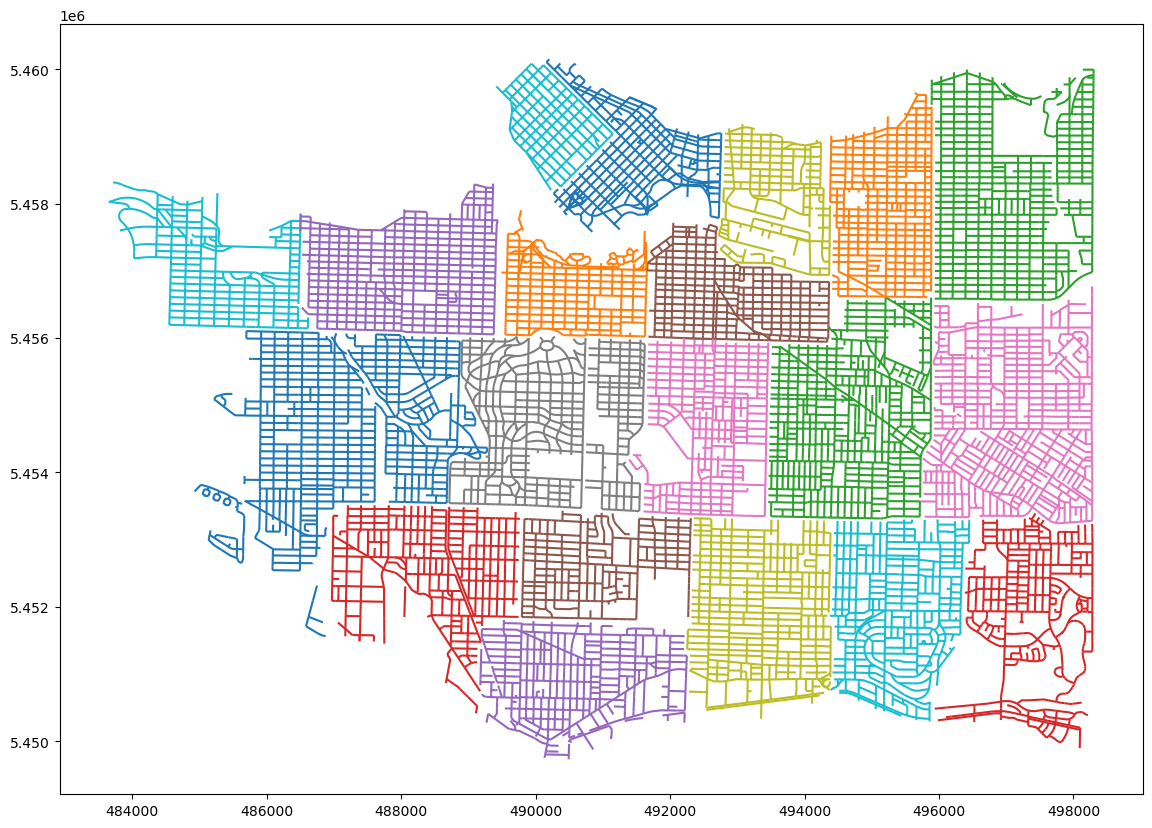

In [116]:
# plotting to confirm grouping by neighbourhood
streets_in_nbrhds.plot("name", figsize=(20,10))

To calculate the total length of public streets per neighbourhood, I came up with the following algorithm.

* Create a Neighbourhood / Total Length Dictionary
    * Create an empty dictionary
    * Iterate the `name` column of neighbourhoods dataframe
    * For each neighbourhood name we iterate through, we will add a key `<neighbourhood name>` with a value of 0.
* Iterate through the `streets_in_nbrhds` dataframe, and use the `name` column entry as the key for the dictionary to add the `length` entry to the value corresponding to that key within the dictionary.

In [117]:
# create a dictionary to hold the values
street_length_dict = {}

for name in nbrhoods["name"]:
    street_length_dict[name] = 0

# iterate through the joined table and add to the values in the dictionary
for length, name in zip(streets_in_nbrhds["length"], streets_in_nbrhds["name"]):
    street_length_dict[name] += length

street_length_dict

{'Strathcona': 38240.87994800333,
 'Killarney': 55840.40152858624,
 'Dunbar-Southlands': 79268.39345052058,
 'West Point Grey': 49680.14083505062,
 'Kerrisdale': 62914.651357618815,
 'Marpole': 64473.003262813996,
 'Oakridge': 43269.079054985225,
 'Fairview': 46948.73357861934,
 'Hastings-Sunrise': 98840.01943986343,
 'Downtown': 55708.780902082355,
 'Sunset': 76619.13215109738,
 'Renfrew-Collingwood': 105784.55701825679,
 'Kitsilano': 83286.40790197742,
 'Arbutus Ridge': 44905.9525632219,
 'Riley Park': 62425.51142200809,
 'Shaughnessy': 58594.537546873806,
 'Grandview-Woodland': 65707.16554263825,
 'Victoria-Fraserview': 70014.47790013523,
 'South Cambie': 24098.893676001422,
 'Kensington-Cedar Cottage': 103734.18206197218,
 'West End': 28334.829818661437,
 'Mount Pleasant': 58807.36740805566}

We can now add our total street lengths, in the proper order, back into our main `nbrhoods` dataframe by iterating through the `name` column in the `nbrhoods` dataframe, and using those neighbourhood names to access the values in our dictionary.

In [118]:
nbrhoods["street length (m)"] = [street_length_dict[name] for name in nbrhoods["name"]]

In [119]:
nbrhoods.head(4)

name                                           geometry  \
19         Strathcona  POLYGON ((492873.076 5459651.115, 492874.972 5...   
17          Killarney  POLYGON ((495859.368 5450489.396, 495859.933 5...   
9   Dunbar-Southlands  POLYGON ((487606.108 5453561.086, 486990.723 5...   
21    West Point Grey  POLYGON ((486506.363 5457849.452, 486470.863 5...   

        Area (m)  tree count  tree per sq. M  street length (m)  
19  3.875907e+06        2837        0.000732       38240.879948  
17  6.669148e+06        6500        0.000975       55840.401529  
9   8.895118e+06        9112        0.001024       79268.393451  
21  4.719099e+06        4841        0.001026       49680.140835

Now using standard dataframe boradcasting, we can create a new column to capture the distance between street trees.

In [120]:
nbrhoods["Distance tween trees m"] = nbrhoods["street length (m)"] / nbrhoods["tree count"]

nbrhoods = nbrhoods.sort_values(by="Distance tween trees m", ascending=False)

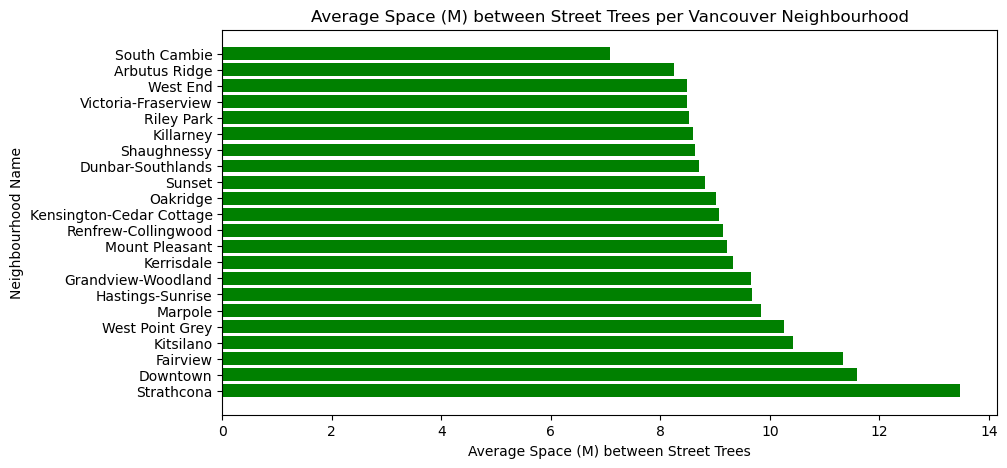

In [122]:
plot_names = list(nbrhoods["name"])
plot_values = list(nbrhoods["Distance tween trees m"])


fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.barh(plot_names, plot_values, color ='green')

plt.xlabel("Average Space (M) between Street Trees")
plt.ylabel("Neighbourhood Name")
plt.title("Average Space (M) between Street Trees per Vancouver Neighbourhood")
plt.show()

---

## CONCLUSION
Approach 3 yielded common sense results. Strathcona which is largely industrial has the largest spacing of street trees. South Cambie which is residential, older, and contains Queen Elizabeth Park has the closest spacing of trees.

South Cambie

<img src="img\cambie.png" width="800"> 

<br>

Strathcona

<img src="img\strathcona.png" width="800"> 


### Limitations

The two images above really point out how zoning affects greenness. If you look to the left of the strathcona image, you will see that the residential street is actually quite *green*. If I were to push this analysis further, I might compare the average street tree spacing *in only residential areas* versus all zoning areas.